In [1]:
#!pip install imblearn
#!pip install xgboost
#pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras.callbacks import History
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

C:\Users\Henry\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [82]:
# cost benefit matrix for calculation in different function
cost_benefit_1 = np.array([[800,-1000],[-50,0]])
cost_benefit_ = pd.DataFrame([[0,-50],[-1000,800]])
cost_benefit_.index.name = 'actual'
cost_benefit_.columns.name = 'predicted'

# print out the accuracy,r2,f1 score for different model
def accuracy_(model,X,y):
    pred = model.predict(X)
    print("accuracy:{accuracy}".format(accuracy=model.score(X, y)))
    print("r2:{r2}".format(r2 = r2_score(y, pred)))
    print("f1:{f1}".format(f1 = f1_score(y,pred)))

# create feature importances for different models
def feat_imp(df, model, n_features):
    d = dict(zip(df.columns, model.feature_importances_))
    ss = sorted(d, key=d.get, reverse=True)
    top_names = ss[0:n_features]
    lst=[]
    for i in ss:
        lst.append(d[i])
    plt.figure(figsize=(15,15))
    plt.title("Feature Importances",fontsize=28)
    plt.barh(range(n_features),(sorted([d[i] for i in top_names],reverse=False)), color="b", align="center")
    plt.yticks(range(n_features), top_names[::-1],fontsize=20)

# calculate the max profit that neural network can generate at certain threshold
def find_best_profit_nn(model,X,y):
    threshold_lst = []
    values_lst = []
    th = np.arange(0.1, 1.1, 0.05)
    for i in th:
        values_lst.append(((nn_confusion_matrix_(model,X,y,threshold=i) * cost_benefit_).values.sum()))
        threshold_lst.append(i)
    profit_result = max(values_lst)
    threshold_result = (threshold_lst[values_lst.index(profit_result)])
    return (profit_result, threshold_result)

# create a roc_curve includes all of the model
def roc_curve_(rf,gdb_model,logistic_model,xgb_model,nn_model,svm_model,X_test,y_test):
    probs = rf.predict_proba(X_test)
    preds = probs[:,1]
    probs1 = gdb_model.predict_proba(X_test)
    preds1 = probs1[:,1]
    probs2 = logistic_model.predict_proba(X_test)
    preds2 = probs2[:,1]
    probs3 = xgb_model.predict_proba(X_test)
    preds3 = probs3[:,1]
    prob4 = nn_model.predict(X_test)
    probs5 = svm_model.predict_proba(X_test1)
    preds5 = probs5[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
    fpr2, tpr2, threshold2 = metrics.roc_curve(y_test, preds2)
    fpr3, tpr3, threshold3 = metrics.roc_curve(y_test, preds3)
    fpr4, tpr4, threshold4 = metrics.roc_curve(y_test, prob4)
    fpr5, tpr5, threshold5 = metrics.roc_curve(y_test, preds5)
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc1 = metrics.auc(fpr1, tpr1)
    roc_auc2 = metrics.auc(fpr2, tpr2)
    roc_auc3 = metrics.auc(fpr3, tpr3)
    roc_auc4 = metrics.auc(fpr4,tpr4)
    roc_auc5 = metrics.auc(fpr5,tpr5)
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = "RF AUC = {0:.1%}".format(round(roc_auc,3)))
    plt.plot(fpr1, tpr1, 'r', label = "GB AUC = {0:.1%}".format(round(roc_auc1,3)))
    plt.plot(fpr2, tpr2, 'g', label = "logistic AUC = {0:.1%}".format(round(roc_auc2,3)))
    plt.plot(fpr3, tpr3, 'k', label = "xgboost AUC = {0:.1%}".format(round(roc_auc3,3)))
    plt.plot(fpr4, tpr4, 'y', label = "neural network AUC = {0:.1%}".format(round(roc_auc4,3)))
    plt.plot(fpr5, tpr5, 'm', label = "SVM AUC = {0:.1%}".format(round(roc_auc5,3)))
    plt.legend(loc = 'lower right',shadow=True)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# create a profit curve to include all of the model
def profit_curve(rf,gdb_model,logistic_model,xgb_model,nn_model,svm_model,X,y):
    thresholds = np.arange(0.0, 1.0, 0.05)
    profits = []
    profits1 = []
    profits2 = []
    profits3 = []
    profits4 = []
    profits5 = []
    for threshold in thresholds:
        profits.append(calculate_payout(cost_benefit_, rf, X,y, threshold))
    for threshold in thresholds:
        profits1.append(calculate_payout(cost_benefit_, gdb_model, X,y, threshold))
    for threshold in thresholds:
        profits2.append(calculate_payout(cost_benefit_, logistic_model, X,y, threshold))
    for threshold in thresholds:
        profits3.append(calculate_payout(cost_benefit_, xgb_model, X,y, threshold))
    for threshold in thresholds:
        profits4.append(nn_calculate_payout(cost_benefit_, nn_model, X,y, threshold))
    for threshold in thresholds:
        profits5.append(calculate_payout(cost_benefit_, svm_model, X_test1,y, threshold))
    fig, ax = plt.subplots()
    ax.plot(thresholds, profits,label = 'random forest',color='r')
    ax.plot(thresholds, profits1,label = 'gradient boost',color='b')
    ax.plot(thresholds, profits2,label='logistic',color='g')
    ax.plot(thresholds, profits3,label='xgb',color='k')
    ax.plot(thresholds, profits4,label='nn',color='y')
    ax.plot(thresholds, profits5,label='svm',color='m')
    ax.legend()
    ax.set_xlabel('thresholds')
    ax.set_ylabel('profits')
    ax.set_title('Profit Curve')
    plt.show()

# return percentage of prediction by threshold
def predict(model, X, threshold=0.5):
    return np.where(model.predict_proba(X)[:, 0] > threshold,
                    model.classes_[0],
                    model.classes_[1])

# calculate the total profit in profit curve graph
def calculate_payout(cost_benefit_, model, X, y,threshold=0.5):
    return (confusion_matrix_(model, X,y, threshold) * cost_benefit_).values.sum()

# create confusion matrix
def confusion_matrix_(model, X,y, threshold=0.5):
    cf = pd.crosstab(y, predict(model, X, threshold))
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

# calculate the max profit for different model in different threshold except neural network
def find_best_profit(model,X,y):
    threshold_lst = []
    values_lst = []
    th = np.arange(0.2, 1.1, 0.05)
    for i in th:
        values_lst.append(((confusion_matrix_(model,X,y,threshold=i) * cost_benefit_).values.sum()))
        threshold_lst.append(i)
    profit_result = max(values_lst)
    threshold_result = (threshold_lst[values_lst.index(profit_result)])
    return (profit_result, threshold_result)

# create custom confusion matrix with threshold and precision recall and total profit
def get_confusion_matrix(model,X,y,threshold):
    tn = confusion_matrix_(model, X,y, threshold=threshold)[0][0]
    fp = confusion_matrix_(model, X,y, threshold=threshold)[1][0]
    fn = confusion_matrix_(model, X,y, threshold=threshold)[0][1]
    tp = confusion_matrix_(model, X,y, threshold=threshold)[1][1]
    print(np.array([[tp, fn], [fp, tn]]))
    print("precision:{precision}, recall:{recall}".format(precision = tp/(tp+fp),recall = tp/(tp+fn)))
    print("total profit:{profit}".format(profit = ((confusion_matrix_(model, X,y, threshold=threshold) * cost_benefit_).values.sum())))
    
# neural network prediction
def nn_predict(model,X,threshold=0.5):
    length_of_nn = len(nn_model.predict(X_test,batch_size=16))
    lst = np.zeros([length_of_nn,2])
    result = lst[:,1].reshape(length_of_nn,1)
    result=(nn_model.predict(X_test,batch_size=32))
    lst[:,1]=result.reshape(length_of_nn)
    lst[:,0]=(1-result.reshape(length_of_nn))
    return np.where(lst[:, 0] > threshold, 0,1)

# neural network confusion matrix
def nn_confusion_matrix_(model,X,y,threshold=0.5):
    cf = pd.crosstab(y, nn_predict(model, X, threshold))
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

# calculate the nn total profit in profit curve graph
def nn_calculate_payout(cost_benefit_, model, X,y, threshold):
    return (nn_confusion_matrix_(model, X,y, threshold) * cost_benefit_).values.sum()

# neural network custom confusion matrix
def nn_get_confusion_matrix(model,X,y,threshold):
    pred = np.argmax(nn_model.predict(X_test,batch_size=16),axis=1)
#     tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
#     print(np.array([[tp, fn], [fp, tn]]))
    tn = nn_confusion_matrix_(model, X,y, threshold=threshold)[0][0]
    fp = nn_confusion_matrix_(model, X,y, threshold=threshold)[1][0]
    fn = nn_confusion_matrix_(model, X,y, threshold=threshold)[0][1]
    tp = nn_confusion_matrix_(model, X,y, threshold=threshold)[1][1]
    print(np.array([[tp, fn], [fp, tn]]))
    print("precision:{precision}, recall:{recall}".format(precision = tp/(tp+fp),recall = tp/(tp+fn)))
    print("total profit:{profit}".format(profit = ((nn_confusion_matrix_(model, X,y, threshold=threshold) * cost_benefit_).values.sum())))

In [4]:
# read the data
data = pd.read_csv('bank-additional-full.csv',sep=';')

In [5]:
# make a copy of the data to edit
new_data = data.copy()

In [6]:
# set parameter to show all columns in pd df
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
# show the number of customer that was not from previous compagin
new_data[new_data["poutcome"]=="nonexistent"]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,37,admin.,married,university.degree,no,yes,no,cellular,nov,fri,281,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no


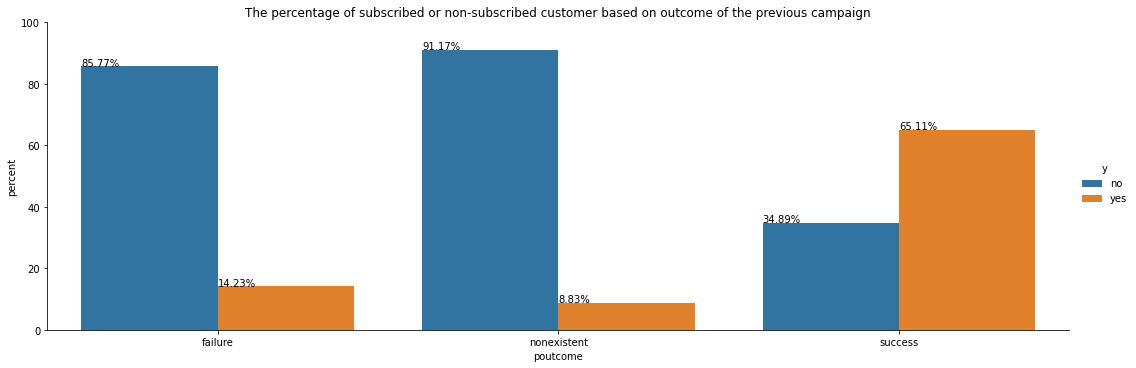

In [8]:
# graph for previous compagin
x = "poutcome"
y = "y"
df2 = data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
g = sns.catplot(x="poutcome",y='percent',hue=y,kind='bar',data=df2, height=5, aspect=3)

g.ax.set_ylim(0,100)
plt.title("The percentage of subscribed or non-subscribed customer based on outcome of the previous campaign")

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [9]:
# check data type for each columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [10]:
# check NAs
new_data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [11]:
# descriptive stats for data set
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [12]:
new_data.y[new_data.y == 'yes'] = 1 # convery label column to int
new_data.y[new_data.y == 'no'] = 0 # convery label column to int

C:\Users\Henry\AppData\Local\Temp/ipykernel_42400/1422105358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.y[new_data.y == 'yes'] = 1 # convery label column to int
C:\Users\Henry\AppData\Local\Temp/ipykernel_42400/1422105358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.y[new_data.y == 'no'] = 0 # convery label column to int


In [13]:
# convert target variable into int64 type
new_data = new_data.astype({'y':'int64'})

In [14]:
# check result
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

<AxesSubplot:xlabel='y', ylabel='age'>

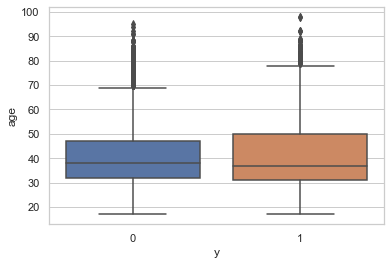

In [15]:
# boxplot for age
sns.set(style='whitegrid')
sns.boxplot(y='age',x='y',data=new_data)

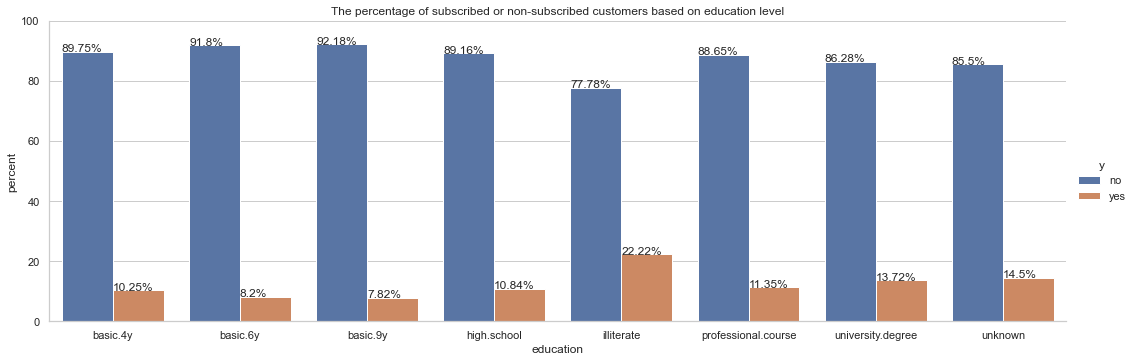

In [16]:
# graph for education level for customers
x = "education"
y = "y"
df2 = data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
g = sns.catplot(x="education",y='percent',hue=y,kind='bar',data=df2, height=5, aspect=3)

g.ax.set_ylim(0,100)
plt.title("The percentage of subscribed or non-subscribed customers based on education level")

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Text(0.5, 1.0, 'The count of subscribed or non-subscribed customer based on education level')

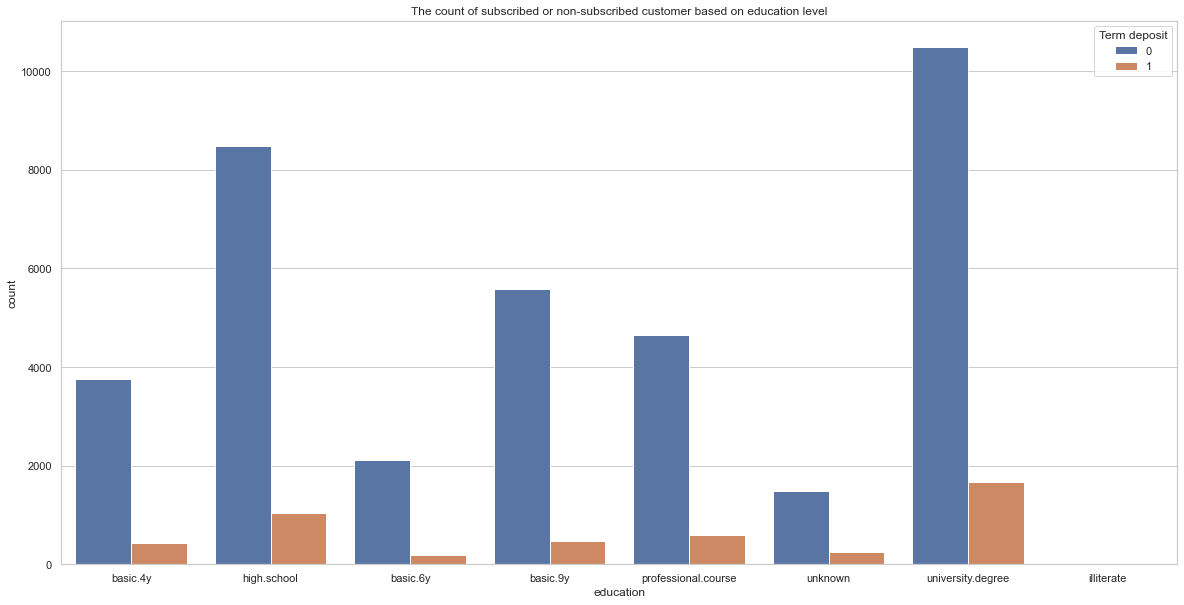

In [17]:
# count plot for education level
plt.figure(figsize=(20,10))
p = sns.countplot(x='education',hue='y',data=new_data)
# ax.legend.new_labels=['no','yes']
leg = p.get_legend()
leg.set_title('Term deposit')
plt.title("The count of subscribed or non-subscribed customer based on education level")

Text(0.5, 1.0, 'The count of subscribed or non-subscribed customer based on age')

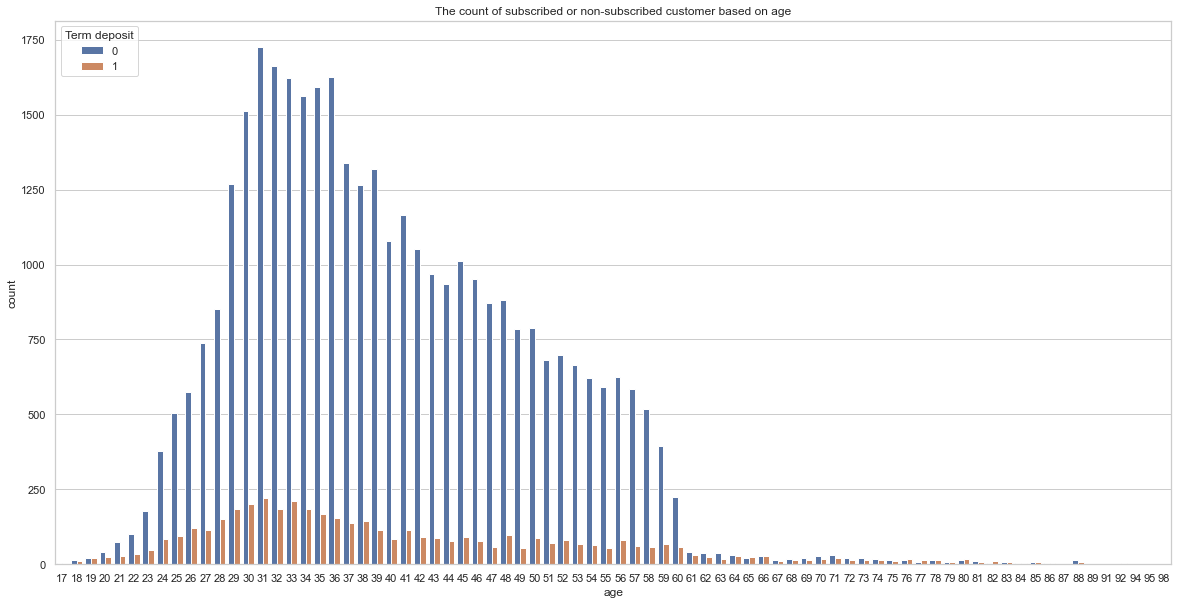

In [18]:
# count plot for age
plt.figure(figsize=(20,10))
p = sns.countplot(x='age',hue='y',data=new_data)
# ax.legend.new_labels=['no','yes']
leg = p.get_legend()
leg.set_title('Term deposit')
plt.title("The count of subscribed or non-subscribed customer based on age")

posx and posy should be finite values
posx and posy should be finite values


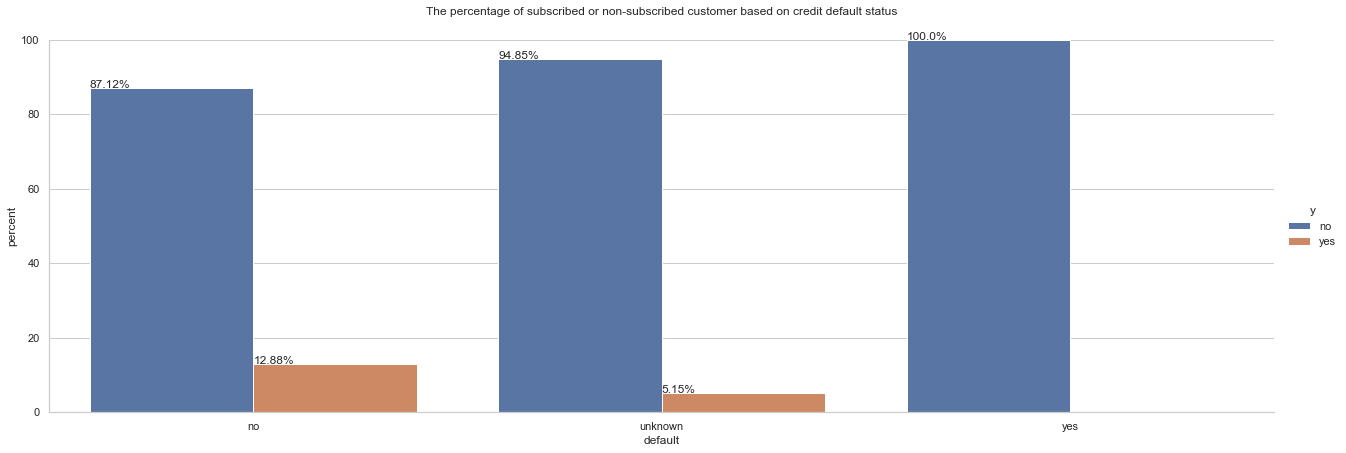

In [19]:
# graph for credit default
x = "default"
y = "y"
df2 = data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
g = sns.catplot(x="default",y='percent',hue=y,kind='bar',data=df2, height=6, aspect=3)

g.ax.set_ylim(0,100)
plt.title("The percentage of subscribed or non-subscribed customer based on credit default status", x=0.5, y=1.05)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Text(0.5, 1.0, 'The count of subscribed or non-subscribed customer based on credit default status')

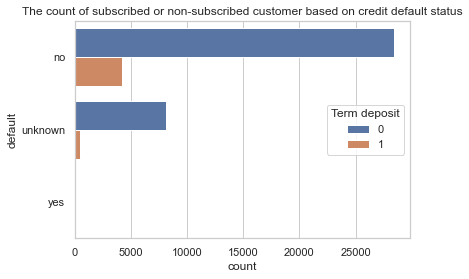

In [20]:
# count plot for credit default
p = sns.countplot(y='default',hue='y',data=new_data)
# ax.legend.new_labels=['no','yes']
leg = p.get_legend()
leg.set_title('Term deposit')
plt.title("The count of subscribed or non-subscribed customer based on credit default status")


In [21]:
# showing 3 credit default customers
new_data[new_data['default'] == 'yes']

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
21580,48,technician,married,professional.course,yes,no,no,cellular,aug,tue,66,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
21581,48,technician,married,professional.course,yes,yes,no,cellular,aug,tue,133,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
24866,31,unemployed,married,high.school,yes,no,no,cellular,nov,tue,111,2,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,0


C:\Users\Henry\AppData\Local\Temp/ipykernel_42400/3579653757.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,5000,10000,15000,20000,25000,30000,35000],fontsize=14)


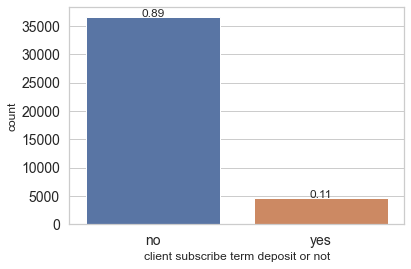

In [22]:
# graph shows imbalance class for the data set
sns.set(style='whitegrid')
ax = sns.countplot(x='y', data=new_data)
total= float(len(new_data.y))
for p in ax.patches:
    height=p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height+20,'{:1.2f}'.format(height/total),ha='center')
ax.set(xlabel='client subscribe term deposit or not')
ax.set_xticklabels(['no','yes'],fontsize=14)
ax.set_yticklabels([0,5000,10000,15000,20000,25000,30000,35000],fontsize=14)
plt.show()

Text(0.5, 1.0, 'The count of subscribed or non-subscribed customer based on contact type')

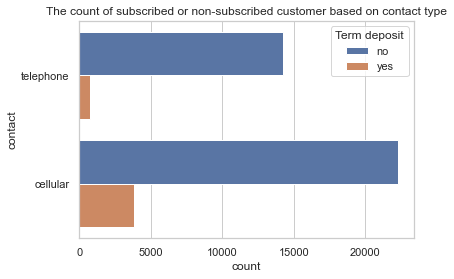

In [23]:
# graph for contact type customers
p = sns.countplot(y='contact',hue='y',data=new_data)
# ax.legend.new_labels=['no','yes']
leg = p.get_legend()
leg.set_title('Term deposit')
labs = leg.texts
labs[0].set_text('no')
labs[1].set_text('yes')
plt.title("The count of subscribed or non-subscribed customer based on contact type")

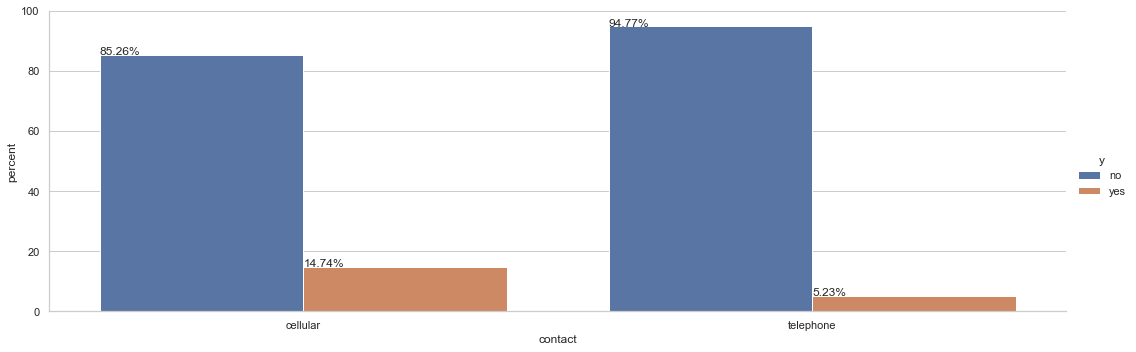

In [24]:
# percentage graph for contact type
x = "contact"
y = "y"
df2 = data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
g = sns.catplot(x="contact",y='percent',hue=y,kind='bar',data=df2, height=5, aspect=3)

g.ax.set_ylim(0,100)


for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [25]:
# one-hot encoding to convert category column into numberic
new_data_df = pd.get_dummies(new_data, columns=['job','marital','education','day_of_week','default','housing','loan',
                                 'contact','month','poutcome'], drop_first=True)


In [26]:
# pick dependent variable for prediction
new_X = new_data_df.loc[:,  new_data_df.columns != 'y'] 


In [27]:
# pick independent variable for validation
new_y = new_data_df.y

In [28]:
new_data_df.y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: y
Non-Null Count  Dtype
--------------  -----
41188 non-null  int64
dtypes: int64(1)
memory usage: 321.9 KB


## train test split

In [29]:
# train test split
X_train,X_test,y_train,y_test = train_test_split(new_X.values,new_y.values,test_size=0.07,random_state=13) # doing train test split

##  resample

In [30]:
# oversample to solve imbalance class
sm = SMOTE(sampling_strategy = 1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [31]:
new_X_train,new_X_test,new_y_train,new_y_test = train_test_split(X_train_res,y_train_res,test_size=0.3,random_state=15)

In [32]:
np.unique(new_y_train, return_counts = True) # checking if data is balance now

(array([0, 1], dtype=int64), array([23786, 23760], dtype=int64))

## Logistic Regression

In [33]:
logistic_model = LogisticRegression(max_iter= 1000,random_state=0,class_weight="balanced",solver="liblinear")

In [34]:
logistic_model.fit(new_X_train,new_y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0,
                   solver='liblinear')

In [35]:
logistic_model.score(new_X_test,new_y_test)

0.875159485719894

In [36]:
logistic_model.score(X_test,y_test)

0.8543689320388349

In [37]:
accuracy_(logistic_model,X_test,y_test)

accuracy:0.8543689320388349
r2:-0.5718089661938051
f1:0.554140127388535


In [38]:
get_confusion_matrix(logistic_model,X_test,y_test,threshold=0.5)
# confusion matrix
#([tp,fn],
#[fp,tn])

[[ 261   37]
 [ 383 2203]]
precision:0.4052795031055901, recall:0.8758389261744967
total profit:152650


## Random Forest

In [39]:
rf = RandomForestClassifier(n_estimators = 5000, max_depth = 6, min_samples_split = 3, random_state=0)

In [40]:
rf.fit(new_X_train,new_y_train)

RandomForestClassifier(max_depth=6, min_samples_split=3, n_estimators=5000,
                       random_state=0)

In [41]:
accuracy_(rf,X_test,y_test)

accuracy:0.8678918169209431
r2:-0.425855276475809
f1:0.5243445692883896


In [42]:
get_confusion_matrix(rf,X_test,y_test,threshold=0.5) 
# confusion matrix
#([tp,fn],
#[fp,tn])

[[ 210   88]
 [ 293 2293]]
precision:0.41749502982107356, recall:0.7046979865771812
total profit:65350


In [43]:
accuracy_(rf,new_X_test,new_y_test) # test validation ,not actual result

accuracy:0.9217783884581411
r2:0.6871130444887488
f1:0.9240156354275909


In [44]:
get_confusion_matrix(rf,new_X_test,new_y_test,threshold=0.5)# test validation ,not actual result

[[9692  510]
 [1084 9092]]
precision:0.8994060876020787, recall:0.9500098019996079
total profit:7189400


## Gradient Boosting

In [45]:
gdb_model = GradientBoostingClassifier(learning_rate = 0.05,random_state=0)

In [46]:
gdb_model.fit(new_X_train,new_y_train)

GradientBoostingClassifier(learning_rate=0.05, random_state=0)

In [47]:
accuracy_(gdb_model,X_test,y_test)

accuracy:0.8952843273231623
r2:-0.13020549473935517
f1:0.598404255319149


In [48]:
get_confusion_matrix(gdb_model,X_test,y_test,threshold=0.5)
# confusion matrix
#([tp,fn],
#[fp,tn])

[[ 225   73]
 [ 229 2357]]
precision:0.4955947136563877, recall:0.7550335570469798
total profit:95550


In [49]:
accuracy_(gdb_model,new_X_test,new_y_test)# test validation ,not actual result

accuracy:0.9366473648051821
r2:0.7465890466969728
f1:0.9382089695113196


In [50]:
get_confusion_matrix(gdb_model,new_X_test,new_y_test,threshold=0.5)# test validation  ,not actual result
# confusion matrix
#([tp,fn],
#[fp,tn])

[[9801  401]
 [ 890 9286]]
precision:0.9167524085679544, recall:0.9606939815722407
total profit:7395300


## XGboost

In [51]:
xgb_model = XGBClassifier(colsample_bytree=0.7,
 learning_rate=0.05,
 max_depth=7,
 min_child_weight=11,
 n_estimators=1000,
 seed=1337,
 silent=1,
 subsample=0.8)


In [52]:
xgb_model.fit(new_X_train,new_y_train)

C:\Users\Henry\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:23:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:23:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=11, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=1337, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=1337, silent=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
accuracy_(xgb_model,X_test,y_test)

accuracy:0.9160887656033287
r2:0.0943386432883313
f1:0.5724381625441696


In [54]:
get_confusion_matrix(xgb_model,X_test,y_test,threshold=0.5)
# confusion matrix
#([tp,fn],
#[fp,tn])

[[ 162  136]
 [ 106 2480]]
precision:0.6044776119402985, recall:0.5436241610738255
total profit:-11700


In [55]:
accuracy_(xgb_model,new_X_test,new_y_test)# test validation, ,not actual result

accuracy:0.9509274708018451
r2:0.8037095636692275
f1:0.9505733491498616


In [56]:
get_confusion_matrix(xgb_model,new_X_test,new_y_test,threshold=0.5)# test validation, ,not actual result
# confusion matrix
#([tp,fn],
#[fp,tn])

[[9616  586]
 [ 414 9762]]
precision:0.9587238285144566, recall:0.9425602822975887
total profit:7086100


## feature importance for XG boosting

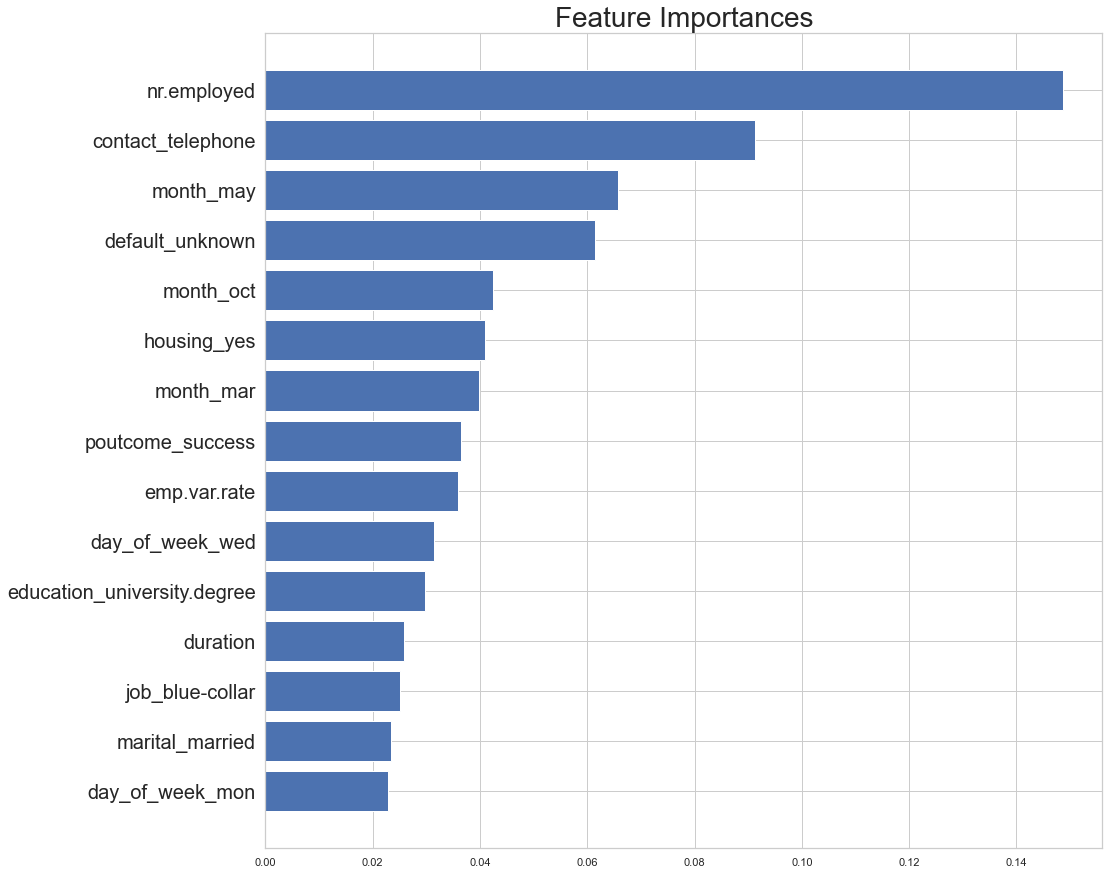

In [58]:
feat_imp(new_X, xgb_model, 15)


# SVM modeling

In [59]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

In [60]:
sc = StandardScaler()
sc.fit(new_X_train)
X_train1 = sc.transform(new_X_train)
X_test1 = sc.transform(X_test)

In [61]:
svm_model = svm.SVC(kernel='rbf',probability=True)
svm_model.fit(X_train1,new_y_train)

SVC(probability=True)

In [62]:
accuracy_(svm_model,X_test1,y_test)

accuracy:0.897364771151179
r2:-0.10775108093658647
f1:0.5830985915492958


In [63]:
get_confusion_matrix(svm_model,X_test1,y_test,threshold=0.5)

[[ 201   97]
 [ 184 2402]]
precision:0.522077922077922, recall:0.674496644295302
total profit:54600


In [64]:
svm_model1 = svm.SVC(kernel='sigmoid',probability=True)
svm_model1.fit(X_train1,new_y_train)

SVC(kernel='sigmoid', probability=True)

In [65]:
accuracy_(svm_model1,X_test1,y_test)

accuracy:0.7850208044382802
r2:-1.3202894262860934
f1:0.4424460431654676


In [66]:
get_confusion_matrix(svm_model1,X_test1,y_test,threshold=0.5)

[[ 238   60]
 [ 525 2061]]
precision:0.3119266055045872, recall:0.7986577181208053
total profit:104150


In [67]:
svm_model2 = svm.SVC(kernel='poly',probability=True)
svm_model2.fit(X_train1,new_y_train)

SVC(kernel='poly', probability=True)

In [68]:
accuracy_(svm_model2,X_test1,y_test)

accuracy:0.8841886269070736
r2:-0.24996236835412122
f1:0.5684754521963824


In [69]:
get_confusion_matrix(svm_model2,X_test1,y_test,threshold=0.5)

[[ 211   87]
 [ 233 2353]]
precision:0.4752252252252252, recall:0.7080536912751678
total profit:70150


## Neural Network

In [70]:
nn_model = tf.keras.models.Sequential()

In [71]:
nn_model.add(keras.layers.Dense(units=100, input_dim=53,activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(keras.layers.Dense(units=50, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(keras.layers.Dense(units=50, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(keras.layers.Dense(units=20, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(keras.layers.Dense(units=15, activation='relu'))


In [72]:
nn_model.add(keras.layers.Dense(units=1,activation='sigmoid'))

In [73]:
ops = tf.keras.optimizers.Adam(learning_rate=0.0001)
nn_model.compile(loss='binary_crossentropy',
              optimizer=ops,
                metrics=[tf.keras.metrics.Recall()])

In [74]:
history = History()

In [75]:
his =nn_model.fit(new_X_train, new_y_train, epochs=50, batch_size=16,validation_data = (new_X_test, new_y_test),
                     callbacks=[history])


Epoch 1/50
2972/2972 [==============================] - 4s 1ms/step - loss: 5.4964 - recall: 0.5352 - val_loss: 0.7027 - val_recall: 0.8540
Epoch 2/50
2972/2972 [==============================] - 3s 1ms/step - loss: 0.9255 - recall: 0.4963 - val_loss: 0.6904 - val_recall: 0.0970
Epoch 3/50
2972/2972 [==============================] - 3s 1ms/step - loss: 0.7303 - recall: 0.4087 - val_loss: 0.6913 - val_recall: 0.0160
Epoch 4/50
2972/2972 [==============================] - 3s 1ms/step - loss: 0.6958 - recall: 0.3848 - val_loss: 0.6478 - val_recall: 0.3628
Epoch 5/50
2972/2972 [==============================] - 3s 1ms/step - loss: 0.6484 - recall: 0.5000 - val_loss: 0.5806 - val_recall: 0.5671
Epoch 6/50
2972/2972 [==============================] - 3s 1ms/step - loss: 0.5889 - recall: 0.6134 - val_loss: 0.5025 - val_recall: 0.6653
Epoch 7/50
2972/2972 [==============================] - 3s 1ms/step - loss: 0.5512 - recall: 0.6569 - val_loss: 0.4947 - val_recall: 0.6667
Epoch 8/50
2972/2972

In [76]:
print(history.history.keys()) # print out names on history

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


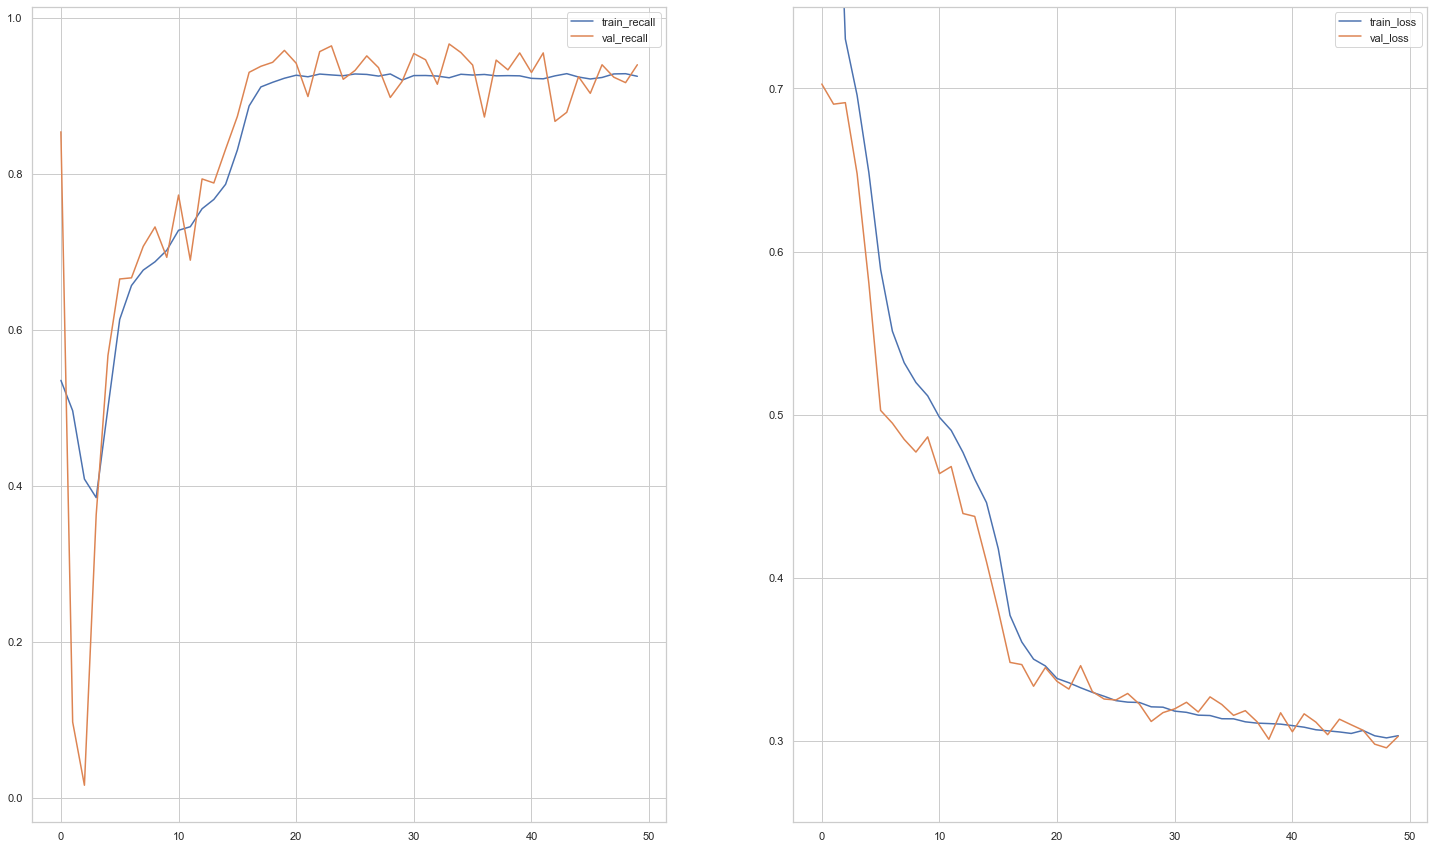

In [77]:
# this is history of validation loss.
# testing if neural network model is working correcting.
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
# everytime you run the neural network model, the history add up. such as (recall,recall_1,recall_2)
train_recall =history.history['recall'] # need to follow the previous cell output to change string
val_recall = history.history['val_recall'] #need to follow the previous cell output to change string
xc         = range(50)

fig,ax = plt.subplots(1,2,figsize=(25,15))

ax[0].plot(xc, train_recall,label='train_recall')
ax[0].plot(xc, val_recall,label='val_recall')
ax[1].plot(xc, train_loss,label='train_loss')
ax[1].plot(xc, val_loss,label='val_loss')

ax[1].set_ylim([0.25,0.75])

ax[0].legend()
ax[1].legend()



In [78]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5400      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                1

In [79]:
nn_get_confusion_matrix(nn_model,X_test,y_test,threshold=0.5)

[[ 278   20]
 [ 462 2124]]
precision:0.37567567567567567, recall:0.9328859060402684
total profit:179300


## Cost Benefit matrix

In [80]:
cost_benefit_ = np.array([[800, -1000], [-50, 0]])
# cost benefit matrix
#([tp,fn],
#[fp,tn])
cost_benefit_

array([[  800, -1000],
       [  -50,     0]])

# Profit Curve

<Figure size 1440x720 with 0 Axes>

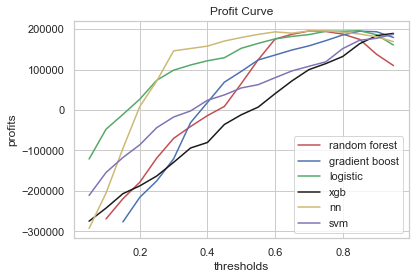

In [83]:
plt.figure(figsize=(20,10))
profit_curve(rf,gdb_model,logistic_model,xgb_model,nn_model,svm_model,X_test,y_test)

# Result

In [84]:
find_best_profit(xgb_model,X_test,y_test)
# result for xgboosting with profit of $192900 threshold 0.9499999999999997

(189450, 0.9499999999999997)

In [85]:
find_best_profit_nn(nn_model,X_test,y_test)
# result for neural network with profit of $194400 threshold 0.7

(195750, 0.7500000000000002)

In [86]:
find_best_profit(rf,X_test,y_test)
# result for random forest with profit of $195150 threshold 0.7

(195350, 0.7)

In [87]:
find_best_profit(gdb_model,X_test,y_test)
# result for gradient boosting with profit of $194950 threshold 0.8499999999999999

(194850, 0.8499999999999999)

In [88]:
find_best_profit(logistic_model,X_test,y_test)
# result for logistic regession with profit of $193800 threshold 0.7499999999999998

(196000, 0.8499999999999999)

In [89]:
find_best_profit(svm_model,X_test1,y_test)
# result for svm with profit of $187450 threshold 0.9499999999999997

(187450, 0.9499999999999997)

In [90]:
find_best_profit(svm_model1,X_test1,y_test)
# result for svm with profit of $154000 threshold 0.6499999999999999

(154000, 0.6499999999999999)

In [91]:
find_best_profit(svm_model2,X_test1,y_test)
# result for svm with profit of $180000 threshold 0.9499999999999997

(180000, 0.9499999999999997)

## ROC curve

In [92]:
metrics.roc_curve(y_test,svm_model.predict_proba(X_test)[:,1])

(array([0., 1.]), array([0., 1.]), array([1.00040322e+00, 4.03219518e-04]))

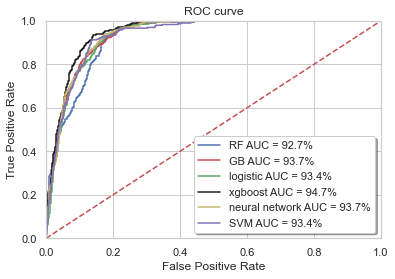

In [93]:
roc_curve_(rf,gdb_model,logistic_model,xgb_model,nn_model,svm_model,X_test,y_test)